In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ANNOTATIONS_PATH = "/content/drive/My Drive/Car Licence Plate Detection Project/Car_Licence_Plate_Detection_Dataset/annotations"  # Update with your path
IMAGES_PATH = "/content/drive/My Drive/Car Licence Plate Detection Project/Car_Licence_Plate_Detection_Dataset/images"

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find("filename").text
    image_path = os.path.join(IMAGES_PATH, filename)

    size = root.find("size")
    orig_width = int(size.find("width").text)
    orig_height = int(size.find("height").text)

    bbox = root.find("object").find("bndbox")
    xmin = int(bbox.find("xmin").text)
    ymin = int(bbox.find("ymin").text)
    xmax = int(bbox.find("xmax").text)
    ymax = int(bbox.find("ymax").text)

    return image_path, (xmin, ymin, xmax, ymax), (orig_width, orig_height)

# Read all annotations
image_paths, bboxes, image_sizes = [], [], []
for xml_file in os.listdir(ANNOTATIONS_PATH):
    if xml_file.endswith(".xml"):
        img_path, bbox, img_size = parse_annotation(os.path.join(ANNOTATIONS_PATH, xml_file))
        image_paths.append(img_path)
        bboxes.append(bbox)
        image_sizes.append(img_size)

In [4]:
IMG_SIZE = 224  # Resize all images to 224x224

def preprocess_data(image_paths, bboxes, image_sizes, img_size=IMG_SIZE):
    X, y = [], []

    for i, img_path in enumerate(image_paths):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (img_size, img_size))
        image = image / 255.0  # Normalize
        X.append(image)

        # Scale bounding box
        orig_w, orig_h = image_sizes[i]
        scale_x, scale_y = img_size / orig_w, img_size / orig_h

        xmin, ymin, xmax, ymax = bboxes[i]
        new_xmin = xmin * scale_x
        new_ymin = ymin * scale_y
        new_xmax = xmax * scale_x
        new_ymax = ymax * scale_y

        y.append([new_xmin, new_ymin, new_xmax, new_ymax])

    return np.array(X), np.array(y)

# Prepare dataset
X, y = preprocess_data(image_paths, bboxes, image_sizes)

# Split into training & testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=89)


In [7]:
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation="linear")(x)  # 4 values for bounding box (xmin, ymin, xmax, ymax)

    model = Model(inputs, outputs)
    return model

model = build_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,068,932 (49.85 MB)

 Trainable params: 13,068,932 (49.85 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
EPOCHS = 500
BATCH_SIZE = 16

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 941.9252 - mae: 23.7670 - val_loss: 1103.2728 - val_mae: 22.6386
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1154.1102 - mae: 25.4100 - val_loss: 1046.8467 - val_mae: 22.0690
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 989.1094 - mae: 24.4625 - val_loss: 1104.1338 - val_mae: 23.5473
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 956.7557 - mae: 24.1415 - val_loss: 1228.8160 - val_mae: 25.4789
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1097.1421 - mae: 25.6335 - val_loss: 968.0806 - val_mae: 20.2642
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 917.3734 - mae: 23.5329 - val_loss: 1034.0096 - val_mae: 22.0273
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1080.1029 - mae: 25.9045 - val_loss: 1236.2729 - val_mae: 25.3031
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 982.6202 - mae: 24.6295 - val_loss: 1134.3892 - val_mae: 23.707

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


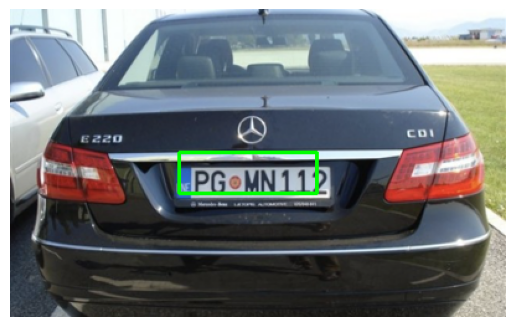

In [10]:
def predict_and_visualize(model, image_path):
    image = cv2.imread(image_path)
    orig_h, orig_w = image.shape[:2]

    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    image_resized = np.expand_dims(image_resized, axis=0)

    pred_bbox = model.predict(image_resized)[0]

    # Scale bounding box back
    scale_x, scale_y = orig_w / IMG_SIZE, orig_h / IMG_SIZE
    xmin, ymin, xmax, ymax = pred_bbox
    xmin, xmax = int(xmin * scale_x), int(xmax * scale_x)
    ymin, ymax = int(ymin * scale_y), int(ymax * scale_y)

    # Draw bounding box
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Test on an image
test_image_path = image_paths[0]  # Pick an image
predict_and_visualize(model, test_image_path)

In [11]:
def predict_and_visualize_multiple(model, image_paths, num_images=15):
    for i in range(min(num_images, len(image_paths))):
        image_path = image_paths[i]
        image = cv2.imread(image_path)
        orig_h, orig_w = image.shape[:2]

        image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
        image_resized = np.expand_dims(image_resized, axis=0)

        pred_bbox = model.predict(image_resized)[0]

        # Scale bounding box back
        scale_x, scale_y = orig_w / IMG_SIZE, orig_h / IMG_SIZE
        xmin, ymin, xmax, ymax = pred_bbox
        xmin, xmax = int(xmin * scale_x), int(xmax * scale_x)
        ymin, ymax = int(ymin * scale_y), int(ymax * scale_y)

        # Draw bounding box
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Image {i + 1}")  # Add title for each image
        plt.axis("off")
        plt.show()

# Predict and visualize for the first 15 images
predict_and_visualize_multiple(model, image_paths, num_images=15)

Output hidden; open in https://colab.research.google.com to view.

Saving 481262006_122145398156433564_7387722132237248806_n.jpg to 481262006_122145398156433564_7387722132237248806_n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


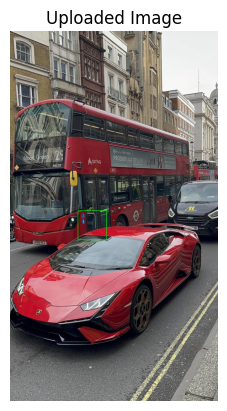

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

def predict_and_visualize_uploaded(model):
    """Predicts the bounding box for an uploaded image and visualizes the result."""

    uploaded = files.upload()
    for fn in uploaded.keys():
        image_path = fn

    image = cv2.imread(image_path)
    orig_h, orig_w = image.shape[:2]

    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    image_resized = np.expand_dims(image_resized, axis=0)

    pred_bbox = model.predict(image_resized)[0]

    # Scale bounding box back
    scale_x, scale_y = orig_w / IMG_SIZE, orig_h / IMG_SIZE
    xmin, ymin, xmax, ymax = pred_bbox
    xmin, xmax = int(xmin * scale_x), int(xmax * scale_x)
    ymin, ymax = int(ymin * scale_y), int(ymax * scale_y)

    # Draw bounding box
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Uploaded Image")  # Add title for each image
    plt.axis("off")
    plt.show()

# Example usage
predict_and_visualize_uploaded(model)